# Data Generation

This is the notebook for generating NeRF data.


In [117]:
import subprocess
import os
import numpy as np
from bs4 import BeautifulSoup as bs
from IPython.display import clear_output
from utils import *

## Define Paths

First we need to specify the directories for the data generation.


In [118]:
obj = "bob"  # the name of the object/dataset you are gonna render. Name the folder and obj file exactly as this string.
base_script = "position" if obj != "sphere" else "test_glint_num"
nori_version = ["nori", "nori_seed1", "nori_seed2", "nori_e10", "nori_e11", "nori_e12", "nori_e13", "nori_e14"][0]
result_dim = 800  # The dimension of the rendered image. Please match the dimension of the images in the dataset used by the pipeline.
light_file_name = "clarens" # You only need to edit this part for the environment map you want to use
light_file_path = f"./env_maps/{light_file_name}.exr"


#############################################
#   Sample Generation Parameters
#############################################
sample_type = "nerf"
nerf_dataset = "chair"  # feel free to use other nerf datasets' camera poses


#############################################
#   Rendering Parameters
#############################################
integrator_type = ["rgba", "mask", "albedo", "normal"][0]  # the type of integrator defined in Nori.
# This case you can just click "run all" without worrying about repetitive data genaration
# If you want to fine tune the rendering parameters, please scroll down to the bottom of the notebook
GENERATE_TRAINING_DATA = False
GENERATE_TESTING_DATA = False


#############################################
#   Post Processing Parameters
#   This part will only work if you have generated both images and masks
#############################################
img_format = "png"
POST_PROCESSING_TRAIN = (
    True  # if you want to apply post processing to the rendered images
)
POST_PROCESSING_TEST = True
black_pixel_threshold = 0.7

In [119]:
cwd = f"{os.getcwd()}"  # the absolute path to the current working directory

scene_file = os.path.join(cwd, "scripts", "render.xml")

# define these two if you want to use the preset camera positions in PhySG
data_path = os.path.join(cwd, "scripts", "camera_poses")
train_cam_file = os.path.join(data_path, f"{nerf_dataset}_transforms_train.json")
test_cam_file = os.path.join(data_path, f"{nerf_dataset}_transforms_test.json")


def get_out_path(category, data_type, data_format):
    return os.path.join("out", "data", f"{obj}_{light_file_name}", category, data_type, data_format)


# training dataset
train_rgba_png_dir = get_out_path("train", "rgba", "png")
train_rgba_exr_dir = get_out_path("train", "rgba", "exr")
train_mask_png_dir = get_out_path("train", "mask", "png")
train_mask_exr_dir = get_out_path("train", "mask", "exr")
train_albedo_png_dir = get_out_path("train", "albedo", "png")
train_albedo_exr_dir = get_out_path("train", "albedo", "exr")
train_normal_png_dir = get_out_path("train", "normal", "png")
train_normal_exr_dir = get_out_path("train", "normal", "exr")

# testing dataset
test_rgba_png_dir = get_out_path("test", "rgba", "png")
test_rgba_exr_dir = get_out_path("test", "rgba", "exr")
test_mask_png_dir = get_out_path("test", "mask", "png")
test_mask_exr_dir = get_out_path("test", "mask", "exr")
test_albedo_png_dir = get_out_path("test", "albedo", "png")
test_albedo_exr_dir = get_out_path("test", "albedo", "exr")
test_normal_png_dir = get_out_path("test", "normal", "png")
test_normal_exr_dir = get_out_path("test", "normal", "exr")

In [120]:
# create those directories if they don't exist
# train
os.makedirs(train_rgba_png_dir, exist_ok=True)
os.makedirs(train_rgba_exr_dir, exist_ok=True)
os.makedirs(train_mask_png_dir, exist_ok=True)
os.makedirs(train_mask_exr_dir, exist_ok=True)
os.makedirs(train_albedo_png_dir, exist_ok=True)
os.makedirs(train_albedo_exr_dir, exist_ok=True)
os.makedirs(train_normal_png_dir, exist_ok=True)
os.makedirs(train_normal_exr_dir, exist_ok=True)
# test
os.makedirs(test_rgba_png_dir, exist_ok=True)
os.makedirs(test_rgba_exr_dir, exist_ok=True)
os.makedirs(test_mask_png_dir, exist_ok=True)
os.makedirs(test_mask_exr_dir, exist_ok=True)
os.makedirs(test_albedo_png_dir, exist_ok=True)
os.makedirs(test_albedo_exr_dir, exist_ok=True)
os.makedirs(test_normal_png_dir, exist_ok=True)
os.makedirs(test_normal_exr_dir, exist_ok=True)

## Get & Visualise Samples


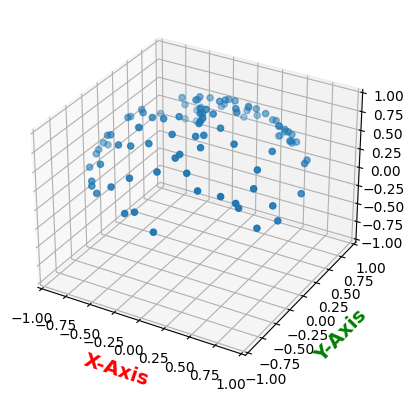

In [121]:
# Getting training samples
# data should already be sorted in the json file
pos = get_points_from_nerf(train_cam_file)
samples_train = np.array(pos)
required_train_points = len(samples_train)

visualise_points(samples_train)

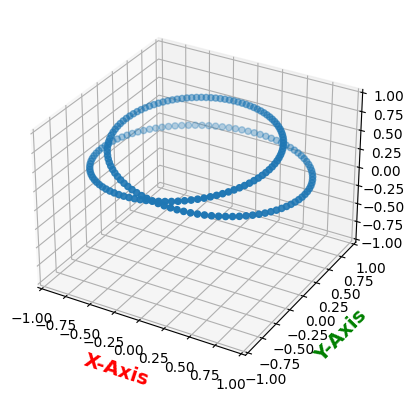

In [122]:
# Getting testing samples
# data should already be sorted in the json file
pos = get_points_from_nerf(test_cam_file)
samples_test = np.array(pos)
required_test_points = len(samples_test)

visualise_points(samples_test)

## Render Required Images


### Define Basic Parameters for Rendering


In [123]:
# params for the .xml file
sampleCount = "32"  # default val
# Somehow changing the sample count by one is like changing the seed of the pseudo random number generator for quadtree??
# While actually changning the seed doesn't work??
# if integrator_type == "rgba":
#     sampleCount = "1024" 
if integrator_type == "rgba":
    sampleCount = "1000"  

fov = "40"  # PhySG default is 35, NeRF default is 40
cam_pos = "0.0, 0.0, 0.0"  # a dummy value
obj_filename = os.path.join("meshes", sample_type, f"{obj}.obj")

# fine-tuning rendering parameters
glints_alpha = "0.5"  # the roughness of the material
light_gamma = "1.0"
light_toWorld = "1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0"

In [124]:
with open(f"./scripts/{base_script}.xml", "r") as f:
    data = f.read()

# create nori .xml script
# the following params will not change for a batch of data
bs_data = bs(data, "xml")
bs_data.find("integrator")["type"] = integrator_type  # set the integrator type
bs_data.find("sampler").find("integer")["value"] = sampleCount  # set the sample count

camera_param = bs_data.find("camera")
for child in camera_param.children:
    if child.name == "float":
        child["value"] = fov
    if child.name == "integer":
        child["value"] = result_dim

if base_script == "position":
    mesh_param = bs_data.find("mesh")
    for child in mesh_param:
        if child.name == "string":
            child["value"] = obj_filename
        if child.name == "bsdf":
            child.find("float")["value"] = glints_alpha

    emitter_param = bs_data.find("emitter")
    for child in emitter_param:
        if child.name == "string":
            child["value"] = light_file_path
        if child.name == "float":
            child["value"] = light_gamma
        if child.name == "transform":
            child.find("matrix")["value"] = light_toWorld
else:
    meshes = bs_data.find_all("mesh")
    for mesh in meshes:
        for child in mesh:
            if child.name == "string":
                cur_obj = child["value"].split("/")[-1]
                child["value"] = os.path.join("meshes", "test_glint_num", cur_obj)

### Define Rendering Main Loop


In [125]:
def get_out_img_path(is_train, img_name):
    if is_train:
        rgba_png_path = os.path.join(cwd, train_rgba_png_dir, f"{img_name}.png")
        rgba_exr_path = os.path.join(cwd, train_rgba_exr_dir, f"{img_name}.exr")
        mask_png_path = os.path.join(cwd, train_mask_png_dir, f"{img_name}.png")
        mask_exr_path = os.path.join(cwd, train_mask_exr_dir, f"{img_name}.exr")
        albedo_png_path = os.path.join(cwd, train_albedo_png_dir, f"{img_name}.png")
        albedo_exr_path = os.path.join(cwd, train_albedo_exr_dir, f"{img_name}.exr")
        normal_png_path = os.path.join(cwd, train_normal_png_dir, f"{img_name}.png")
        normal_exr_path = os.path.join(cwd, train_normal_exr_dir, f"{img_name}.exr")
    else:
        rgba_png_path = os.path.join(cwd, test_rgba_png_dir, f"{img_name}.png")
        rgba_exr_path = os.path.join(cwd, test_rgba_exr_dir, f"{img_name}.exr")
        mask_png_path = os.path.join(cwd, test_mask_png_dir, f"{img_name}.png")
        mask_exr_path = os.path.join(cwd, test_mask_exr_dir, f"{img_name}.exr")
        albedo_png_path = os.path.join(cwd, test_albedo_png_dir, f"{img_name}.png")
        albedo_exr_path = os.path.join(cwd, test_albedo_exr_dir, f"{img_name}.exr")
        normal_png_path = os.path.join(cwd, test_normal_png_dir, f"{img_name}.png")
        normal_exr_path = os.path.join(cwd, test_normal_exr_dir, f"{img_name}.exr")

    return rgba_png_path, rgba_exr_path, mask_png_path, mask_exr_path, albedo_png_path, albedo_exr_path, normal_png_path, normal_exr_path

In [126]:
def move_output_imgs(rgba_png_path, rgba_exr_path, mask_png_path, mask_exr_path, albedo_png_path, albedo_exr_path, normal_png_path, normal_exr_path):
    cur_integrator = bs_data.find("integrator")["type"]
    if cur_integrator == "rgba":
        subprocess.Popen(["mv", "render.png", rgba_png_path], cwd=f"{cwd}/scripts").wait()
        subprocess.Popen(["mv", "render.exr", rgba_exr_path], cwd=f"{cwd}/scripts").wait()
    elif cur_integrator == "mask":
        subprocess.Popen(
            ["mv", "render.png", mask_png_path], cwd=f"{cwd}/scripts"
        ).wait()
        subprocess.Popen(
            ["mv", "render.exr", mask_exr_path], cwd=f"{cwd}/scripts"
        ).wait()
    elif cur_integrator == "albedo":
        subprocess.Popen(
            ["mv", "render.png", albedo_png_path], cwd=f"{cwd}/scripts"
        ).wait()
        subprocess.Popen(
            ["mv", "render.exr", albedo_exr_path], cwd=f"{cwd}/scripts"
        ).wait()
    elif cur_integrator == "normal":
        subprocess.Popen(
            ["mv", "render.png", normal_png_path], cwd=f"{cwd}/scripts"
        ).wait()
        subprocess.Popen(
            ["mv", "render.exr", normal_exr_path], cwd=f"{cwd}/scripts"
        ).wait()
    else:
        raise ValueError(f"Invalid integrator type: {cur_integrator}.")

In [127]:
def render_imgs(required_points, samples_lst, is_train):
    for i in range(required_points):
        cur_sample = samples_lst[i]
        if is_train:
            print(
                f"Rendering train {integrator_type} image {i} at camera position: {cur_sample}..."
            )
        else:
            print(
                f"Rendering test {integrator_type} image {i} at camera position: {cur_sample}..."
            )

        cur_sample = rotate_around_x(cur_sample, 90)
        cur_sample = rotate_around_z(cur_sample, -180)

        cam_pos = str(cur_sample.tolist()).replace("[", "").replace("]", "")

        camera_param = bs_data.find("camera")
        for child in camera_param.children:
            if child.name == "transform":
                child.find("lookat")["origin"] = cam_pos

        with open(scene_file, "wb") as f:
            f.write(str(bs_data.prettify()).encode())

        # stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT hides the console output
        subprocess.Popen(
            [f"./{nori_version}", scene_file, "--no-gui"],
            cwd="./",
            stdout=subprocess.DEVNULL,
            stderr=subprocess.STDOUT,
        ).wait()

        picture_name = f"r_{i}"
        rgba_png_path, rgba_exr_path, mask_png_path, mask_exr_path, albedo_png_path, albedo_exr_path, normal_png_path, normal_exr_path = get_out_img_path(is_train, picture_name)
        move_output_imgs(rgba_png_path, rgba_exr_path, mask_png_path, mask_exr_path, albedo_png_path, albedo_exr_path, normal_png_path, normal_exr_path)

        # clear_output()

    #  Apparently the rendered masks do not give (255,255,255) for the parts that are
    #  supposed to be purely white. So we need to correct the pixel colour
    if bs_data.find("integrator")["type"] == "mask":
        if is_train:
            replace_masks(train_mask_png_dir)
        else:
            replace_masks(test_mask_png_dir)

In [128]:
if GENERATE_TRAINING_DATA:
    render_imgs(required_train_points, samples_train, True)
if GENERATE_TESTING_DATA:
    render_imgs(required_test_points, samples_test, False)

## Post Processing

This step combines the images and masks by removing the background of the images where the corresponding mask pixels are close to black.


In [129]:
# post processing results directory
post_input_dir = os.path.join("out", "data", f"{obj}_{light_file_name}")
post_output_dir = os.path.join("out", "post_res", sample_type, f"{obj}_{light_file_name}")

os.makedirs(post_output_dir, exist_ok=True)

In [130]:
if integrator_type == "mask":
    raise ValueError("Integrator type is mask. Please change it to rgba, albedo or normal.")

if POST_PROCESSING_TRAIN:
    process_rendered_results_with_mask(
        post_input_dir,
        post_output_dir,
        "train",
        integrator_type,
        img_format,
        black_pixel_threshold,
    )
if POST_PROCESSING_TEST:
    process_rendered_results_with_mask(
        post_input_dir,
        post_output_dir,
        "test",
        integrator_type,
        img_format,
        black_pixel_threshold,
    )


Processing train image r_80.png...
Processing train image r_94.png...
Processing train image r_43.png...
Processing train image r_57.png...
Processing train image r_56.png...
Processing train image r_42.png...
Processing train image r_95.png...
Processing train image r_81.png...
Processing train image r_97.png...
Processing train image r_83.png...
Processing train image r_54.png...
Processing train image r_40.png...
Processing train image r_68.png...
Processing train image r_69.png...
Processing train image r_41.png...
Processing train image r_55.png...
Processing train image r_82.png...
Processing train image r_96.png...
Processing train image r_9.png...
Processing train image r_92.png...
Processing train image r_86.png...
Processing train image r_79.png...
Processing train image r_51.png...
Processing train image r_45.png...
Processing train image r_44.png...
Processing train image r_50.png...
Processing train image r_78.png...
Processing train image r_87.png...
Processing train imag